# MNIST Digit Classification with TensorFlow

Richard Corrado <richcorrado@gmail.com> March 2017

An introduction to the MNIST digit database and the classification problem using Random Forests can be found in the notebook MNIST_Digits-overview.ipynb at <https://github.com/richcorrado/MNIST-digits>. A readable html version is at <https://richcorrado.github.io/MNIST_Digits-overview.html>.   Our results there, which we'll consider baseline results for the purposes of this notebook were:
<table align="left">
<tr><th>Model</th><th>Accuracy</th></tr>
<tr><td>Random Forest</td><td>0.964</td></tr>
<tr><td>Random Forest (drop zero padding)</td><td>0.983</td></tr>
</table>
<br><br><br><br><br>

In this notebook, we'll be using TensorFlow to apply neural networks to the MNIST digits. In particular, we'll learn:

1. How to use scikit-learn to perform a one-hot encoding of ordinal class labels, suitable for "one vs all" multiclass classification.

2. How to use scikit-learn functions to standardize features, including the case where we want to preserve some sparsity of features.

3. What the TensorFlow Computational Graph framework is and what classes are introduced by TensorFlow to implement it.

4. How to build a TensorFlow Session by organizing TensorFlow classes to specify the graph, parameters, cost function, optimizer.

5. How to run the TensorFlow session to train the model, compute metrics and make predictions.

We're going to be using the same datasets (saved as csv in an "input" directory) and validation splits, so we'll steal the code from the overview notebook to set everything up. We'll also import the other libraries that were used in that notebook that we'll also be using here.  We will make an effort to import and explain new tools as we need them.

N.B. This notebook should run in 8GB of RAM.  If you have less than that, you will probably have to adjust the code for the convolutional neural network to compute even less features.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.precision',5)
pd.set_option('display.max_colwidth',100)

import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
from matplotlib import pyplot
rcParams['figure.figsize'] = 12, 4
%matplotlib inline

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from time import time
import scipy

Load dataset.  Again, we'll only be using the kaggle train dataset in this notebook.

In [2]:
train_df = pd.read_csv("./input/train.csv")
test_df = pd.read_csv("./input/test.csv")

The data consist of handwritten digits that have been processed by recording the greyscale intensity of a 28x28 array of pixels. These pixel intensity matrices have been unrolled into a vector of 784 features.  Details are in the overview notebook.  Here we reproduce the code to select 16 random images from the training data and display them:

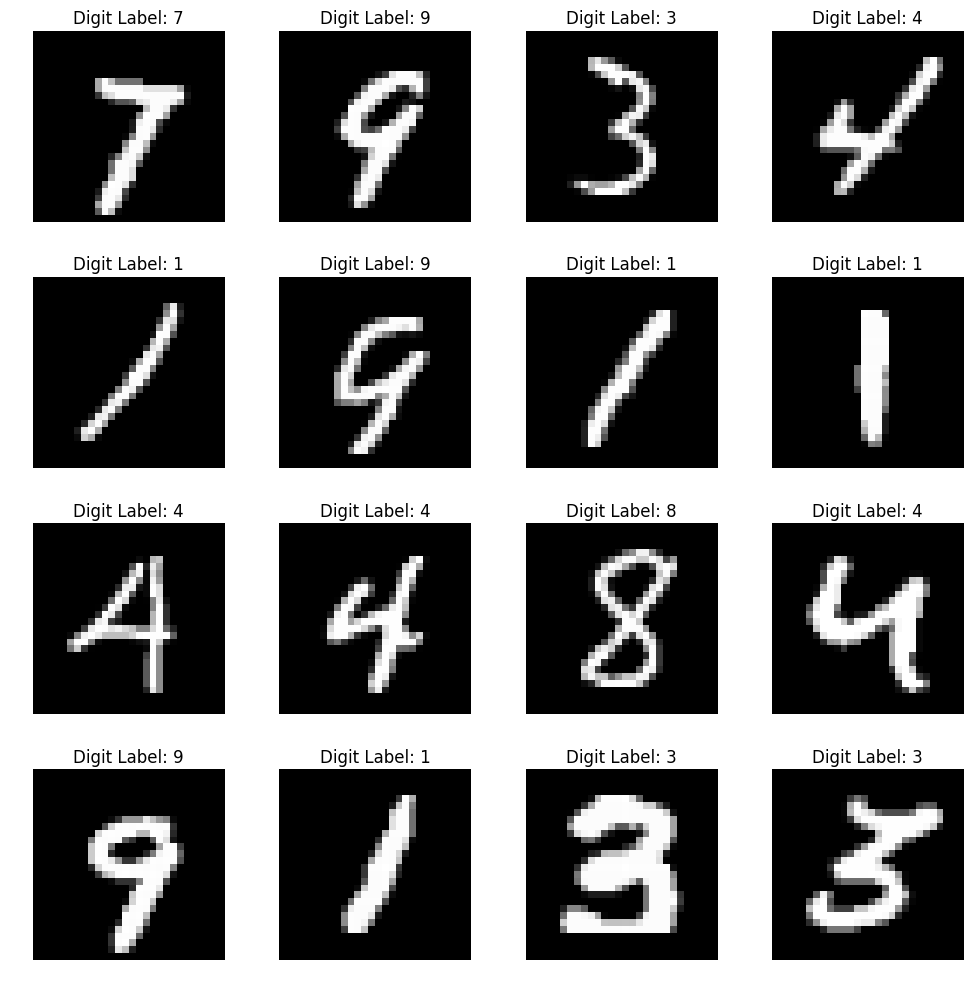

In [3]:
# recover the 28x28 matrix from a row of train_df
def pixel_mat(row):
    # we're working with train_df so we want to drop the label column
    vec = train_df.drop('label', axis=1).iloc[row].values
    # numpy provides the reshape() function to reorganize arrays into specified shapes
    pixel_mat = vec.reshape(28,28)
    return pixel_mat

# generate a list of 16 random rows which are our digits
rand_idx = np.random.choice(train_df.index, size=16, replace=False)
# generate a 4x4 grid of subplots
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(10,10))

# define counter over rand_idx list elements
i = 0
# axs is a 4x4 array so we flatten it into a vector in order to loop over it
for ax in axs.reshape(-1):
    # Title is digit label, which can be found by referencing the label column of the row specified by rand_idx[i]
    ax.set_title("Digit Label: %d" % train_df['label'].iloc[rand_idx[i]])
    # pixel_mat(rand_idx[i]) is the pixel matrix. 
    # The imshow flags are the ones that are used in the matshow wrapper
    ax.imshow(pixel_mat(rand_idx[i]), cmap=plt.cm.gray, origin='upper', interpolation='nearest')
    ax.axis('off')
    i += 1
# tight_layout gives more spacing between subplots    
plt.tight_layout()   
# Tell matplotlib to draw all of the previously generated objects
plt.show()

In the overview, we noted that many features correspond to zero padding, i.e., these pixels are always blank over either the training or test datasets.  These are the list of zero variation features.  We probably won't use them in this notebook, but they are included so that you can utilize them in your own explorations.

In [4]:
zero_cols = list(set(train_df.columns[(train_df == 0).all()].tolist() + test_df.columns[(test_df == 0).all()].tolist()))
len(zero_cols)

94

We generate the same (using random seeds) training, validation and tuning sets as in the overview notebook.

In [5]:
y_train = train_df['label'].values
x_train = train_df.drop(['label'], axis=1).values

In [6]:
validation_split = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=46)

training_idx, validation_idx = list(validation_split.split(x_train, y_train))[0]

training_df = train_df.iloc[training_idx]
validation_df = train_df.iloc[validation_idx]

x_training = training_df.drop(['label'], axis=1).values
y_training = training_df['label'].values

x_validation = validation_df.drop(['label'], axis=1).values
y_validation = validation_df['label'].values

In [7]:
tuning_split = StratifiedShuffleSplit(n_splits=1, train_size=0.15, random_state=96)

tune_idx = list(tuning_split.split(x_training, y_training))[0][0]

x_tune = x_training[tune_idx]
y_tune = y_training[tune_idx]

## One-hot Encoding of the Class Labels

In this dataset, the class labels are encoded as integers 0-9.  This posed no difficulty, as many scikit-learn classification models are designed to properly treat the multiclass problem using this type of encoding.  However, TensorFlow (TF) is designed to allow very low-level design of models. Therefore, it is necessary to provide the framework to treat multiclass classification as part of the TF computation graph.   

In preparation for this, we will encode the class labels as 10d vectors rather than as integers,

$$ 0 \longrightarrow \begin{pmatrix} 1 \\ 0 \\ \vdots \\ 0 \end{pmatrix},
 1 \longrightarrow \begin{pmatrix} 0 \\ 1 \\ \vdots  \\ 0 \end{pmatrix}, \ldots
  9 \longrightarrow \begin{pmatrix} 0 \\ 0 \\ \vdots \\ 1 \end{pmatrix}.$$
  
This is sometimes called "one hot" encoding, since the presence of a defining class is indicated by a binary 1 in a vector and is analogous to the implementation of binary logic in circuits.  In the context of classification, this scheme is called "one vs all" classification and is fairly easy to implement  as an additional layer of our model in TF.  In scikit-learn, one vs all is already build into the multiclassification models so that the end user does not have to perform this additional step.

N.B. If you have already seen one hot encoding of categorical features, you might notice that our encoding here is a reducible representation of the class labels.  That is, we have 10 class labels and we could actually encode them using 9 bits by assigning one of the classes to the 0....0 representative. Such an irreducible representation is preferred for the levels of a categorical feature, but not for a class label.  This is because, if we use the reducible representation here, we can easily apply an argmax function to an output vector to determine the class.  If we had used the irreducible representation, we'd need an extra step to map an output vector matching 0...0 to the last class.  This is an unnecessary complication, so we just use the reducible representation.

To accomplish this encoding easily, we can use the OneHotEncoder or LabelBinarizer from scikit-learn. Since we are dealing with class labels, we will use LabelBinarizer.  This uses the fit, then predict/transform, methods common to the scikit-learn functions.

In [8]:
from sklearn.preprocessing import LabelBinarizer

In [9]:
lb = LabelBinarizer()

In [10]:
lb.fit(y_train)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

We can see explictly how the labels are transformed by applying the transformation to:

In [11]:
range(10)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

whose elements are mapped to 

In [12]:
lb.transform(range(10))

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

which can be compared to the equations written above.

We apply the transformation to all of our response vectors:

In [13]:
y_train_oh = lb.transform(y_train)
y_training_oh = lb.transform(y_training)
y_validation_oh = lb.transform(y_validation)
y_tune_oh = lb.transform(y_tune)

## Standardizing the Data

We'll be using neural networks in this notebook.  Since the connections between layers of a neural network are made via linear models (with weights as slopes and biases as intercepts) and the weights are typically determined through some version of gradient descent, we will want to standardize our data in some way. 

Let's briefly see why we'd want to do this in a case where we have two features $x_1, x_2$ and a response $y$. Suppose also that we are using the residual sum of squares as our cost function.  So our learning algorithm will be attempting to minimize

$$ J(w,b) = \sum | w_1 x_1 + w_2 x_2 + b - y |^2,$$

where the sum is over the rows of our training data. In gradient descent, which is typically used as part of a backpropagation algorithm, we will be computing the derivatives

$$ \frac{\partial J}{\partial w_i} = 2 \sum x_i (w_1 x_1 + w_2 x_2 + b - y).$$

If the range of $x_1$ and $x_2$ are very different, then the corresponding derivatives will also range over very different values, owing to the factor of $x_i$.  For example, if our model was about house prices, $x_1$ could be the living area, with typical value 2000 sq ft, while $x_2$ is the number of bedrooms, which might be 2 or 3 in most cases.

In this example $\partial J/\partial x_1$ will typically be 1000 times as large as $\partial J/\partial x_2$  and this might, in the best case, mean that gradient descent takes much longer to converge.  In a more complicated example, in the worst case, since activation functions destroy convexivity, gradient descent might get stuck at a poor local minimum.

For these reasons, it is a good practice to standardize the features in some way so that their range of variation is similar.  There are various ways of doing this.  For example, in statistics when we say that variables have been standardized, we usually mean the z-score,

$$ z = \frac{x - \mu}{\sigma},$$

where $\mu$ and $\sigma$ are the mean and standard deviation, respectively, over the measured values of $x$.  This has the obvious advantages that the mean of the new variable $\bar{z} = 0$ and standard deviation $\sigma_z = 1$.  In scikit-learn, the function for applying this transformation is found in the preprocessing kit and called <a href="http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html">StandardScaler</a>.

Another type of standardization is to scale the data to a given range, by using the max and min values of the unscaled data. We can first scale to the range $[0,1]$ via

$$ x_\text{std} = \frac{ x - x_\text{min} }{ x_\text{max} - x_\text{min} }, $$

then to the range $[a,b]$ via

$$ x_\text{scaled} = \frac{ x_\text{std} }{b -a  } + a. $$

The scikit-learn function for this is <a href ="http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html">MinMaxScaler</a>.

We can also rescale data to the range $[-1,1]$ by dividing by the maximal absolute value in the unscaled data,

$$ x_\text{scaled} = \frac{ x }{ \text{max}( |x_\text{min}|,|x_\text{max}|)} $$

This transformation has the advantage that sparse data remains sparse, i.e., if $x=0$, then $x_\text{scaled} =0$.  By contrast, the z-score sends values $x = 0$ to $z=-\mu$, destroying sparsity. The scikit-learn function for this is <a href ="http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html">MaxAbsScaler</a>.

The MNIST data is relatively sparse, since 80% of the pixels are blank, so it is a good idea to use a rescaling that preserves the sparseness.  Since the pixel intensities are always nonnegative, it really doesn't matter whether we use MinMaxScaler or MaxAbsScaler, but we'll use MaxAbsScaler to emphasize that it preserves sparsity in the general case.

In [14]:
from sklearn.preprocessing import MaxAbsScaler

The proper way to use these scaling functions is to fit them on just the training data, then separately transform the training and validation sets.  This is so that we don't introduce any bias in the training data by using properties of our validation data.  First we assign an object to the function,

In [15]:
training_scaler = MaxAbsScaler()

We fit this to x_training,

In [16]:
training_scaler.fit(x_training)

MaxAbsScaler(copy=True)

Then transform the associated data sets.

In [17]:
x_training_scaled = training_scaler.transform(x_training)
x_validation_scaled = training_scaler.transform(x_validation)

We can compare the nonzero values of the scaled data to the unscaled data to see how this worked:

In [18]:
x_training_scaled[np.where(x_training_scaled != 0)]

array([ 0.02352941,  0.5372549 ,  0.87058824, ...,  0.65098039,
        0.43921569,  0.12941176])

In [19]:
x_training[np.where(x_training != 0)]

array([  6, 137, 222, ..., 166, 112,  33])

The scaling functions also provide a fit_transform method to train on and then transform the training data in one step. We can apply this to our tuning data, since that doesn't have an associated validation set.

In [20]:
tuning_scaler = MaxAbsScaler()

x_tune_scaled = tuning_scaler.fit_transform(x_tune)

N.B. The MNIST data is actually standardized to the interval [0,255].  However, a general real-world dataset that you encounter will not be, so we made sure to cover the best practice in this notebook.

## TensorFlow

There is already a tutorial about using TensorFlow to study MNIST at <https://www.tensorflow.org/get_started/mnist/pros>.  In our case,  we have been using the data from the kaggle playground, so we won't follow that tutorial exactly, but it is a good place to start. If you haven't installed tensorflow, be sure and do so using the instructions for your OS at <https://www.tensorflow.org/install/>.

TensorFlow (TF) uses a <a herf="https://www.tensorflow.org/get_started/get_started#the_computational_graph">**Computational Graph**</a> model of defining computations.  We can think of each operation as a node of a graph, which is precisely how we organize a neural network. It is worthwhile to describe the detail of a computational graph, since understanding the structure is very important in successful construction of new models.

When using scikit-learn models, we most likely only have to deal with the data in the form of a design matrix and, for training data, a response vector (or matrix in multivariate or possibly multiclass problems).   The user can ignore many details of how the model functions transform the data and implement the particular machine learning algorithms.  However, since TF is intended to be a much lower-level framework for constructing models, it allows that inputs or intermediate expressions can be tensors of any shape.  

In order to handle this,  TF includes a new class called **Tensor** that is used to pass numpy arrays of any shape from one Operation to another. We can think of these as the lines in the graph. In TF an **Operation** is a class that performs a computation on Tensors.  Operations (also called ops) are the nodes of the graph. TF operations include very simple arithmetic like addition tf.add(a.b) or multiplication tf.matmul(a, b), for tensors a,b. Operations also include neural net activation functions and convolution and pooling operations.

In order to specify model parameters, such as weights and biases, TF provides the constructor class **Variable()**. In terms of the computational graph, calling Variable() actually adds two ops. The first is an assign op that assigns the initial value that you specify for the variable, while the second is an op that holds the value of the variable,  which can be changed during learning rounds.

In addition to the computational graph, TF is also based on a mechanism of Feeding data and variables into the computational graph.  In order to facilitate this, TF provides a class called **Placeholder** that can be used to pass a design matrix or hyperparameter into the appropriate operation of the graph.  For instance, the input and output layers of a neural network will be specified by placeholders of the appropriate shape.  Hyperparameters such as learning rates or hidden layer widths can also be specified by placeholders.   The **feed dictionary** has the format ```feed_dict = {placeholder1: array1, placeholder2: array2, ...}```, where placeholder# is the name assigned to the placeholder and array# is a numpy array (can also be a single number when appropriate).

The mechanics of using TF is the following: 

1. We define a TF instance or session using the class Session() or, for notebooks, InteractiveSession(), e.g., sess = tf.InteractiveSession()

2. We specify the computational graph using the necessary Placeholders, Variables and Operations.

3. We define functions of the graph outputs, like the cost function.  TF will treat these as tensor class objects.

4. We specify an optimizer, typically using the method .minimize(cost_function). For example, optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

5. Training is accomplished using the .run method on the session. For example, we might run sess.run([optimizer, cost], feed_dict=feed_dict).   This feeds the values of all placeholders using a python dictionary named feed_dict, accomplishing feedforward computation of the cost function and backpropagation using the specified optimizer. We can iterate the sess.run method for as many training epochs as needed.

6. Validation can be accomplished by executing sess.run while feeding in the validation data to the input placeholders. In addition to the cost function, we can evaluate other metrics by defining the appropriate function and specifying it in sess.run.

7. Prediction is also accomplished via sess.run, now using the new data and specifying the output variable or an appropriate function thereof.

A complication of the TF methodology is that during design of the computational graph, it is not too easy to remove or redefine parts of the graph that we've already defined. If we want to change an earlier step of the graph, it can be simplest to just delete the old graph with the command tf.reset_default_graph() and start over.

## Logistic Regression

It is best to illustrate the mechanics of TF with a simple model.  Therefore we will implement logistic regression, which requires specifying the computational graph, cost function, optimizer, etc., but doesn't require introducing neural network technology.  After understanding the TF application here, we will introduce various types of neural network layers and the TF implementation of them.

While we're not exactly defining a neural network yet, we will still use the terminology of layers to describe the computational graph for the logistic regression model.  This is both because the layer structure is built in to the TF design and also because, as we'll see later, logistic regression is, in fact, a very simple form of neural network.  Neural networks should actually be thought of as a framework for generalizing and combining other type of ML models, though combination and composition of simple functions.

We will begin by importing TensorFlow and starting an interactive session.

In [21]:
import tensorflow as tf
sess = tf.InteractiveSession()

The first part of the computational graph will generally be the specification of an **input layer**.  The purpose of the input layer is to provide a data structure into which we'll feed our design matrix when we run the session.

We know that we have 784 features/columns in our design matrix.  However, we have training and validation sets with different number of examples/rows.  TF allows us to introduce placeholder variables with size None to facilitate feeding data sets of different sizes into the same computational graph:

In [22]:
n_feat = 784
x = tf.placeholder(tf.float32, shape=[None, n_feat])

We'll also specify a placeholder for our target output values. We transformed these to one-hot 10d vectors.

In [23]:
n_class = 10
y_true = tf.placeholder(tf.int32, shape=[None, n_class])

Recall that logistic regression applies a linear model

$$ \mathbf{z} = \mathbf{X W }+ \mathbf{b}$$

to compute a linear output $\mathbf{z}$ of shape (# of examples) X (# of classes), which we can call the logits.  The next step is to apply the softmax function to obtain the model class probabilities:

$$ p_{i, c} = \text{softmax}(z_i)_c = \frac{\exp (z_{i,c})}{\sum_{c'} \exp (z_{i,c'})}.$$

Finally, we can make actual class predictions by setting $\hat{y_i}=c$, for $c$ corresponding to the largest computed probability, using an appropriate argmax function in practice.

To implement this in TF, we specify a layer to compute the linear model above.  We have to specify the weights $\mathbf{W}$, which correspond to a tensor of shape [n_feat, n_class] and the biases, which are a vector of shape [n_class].  We use the Variable() class to define both with zero initial values:

In [24]:
W = tf.Variable(tf.zeros([n_feat, n_class]))
b = tf.Variable(tf.zeros([n_class]))

tf.zeros is the TF version of numpy zeros that creates a TF Tensor rather than a numpy array data structure. 

To complete the definition of the layer, we specify the linear model for the logits:

In [25]:
z_out = tf.add(tf.matmul(x, W), b)

We use the TF function matmul to multiply Tensors and add to add them.  We could also have used "+", since TF overloads that operator to properly handle Tensor objects.  The object z_out defined by this statement is created as a Tensor and cast into the shape and data type appropriate from the operation:

In [26]:
z_out

<tf.Tensor 'Add:0' shape=(?, 10) dtype=float32>

We can call this layer, the **output layer**, since it returns an array that is in 1-1 correspondence with the model prediction. At this point, we could apply the softmax function to obtain the class probabilities and then define a **cost function** using the cross-entropy.  However, since this is a very common step, TF includes a version of the cross-entropy function that accepts the logits as inputs:

In [27]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=z_out))

The function tf.nn.softmax_cross_entropy_with_logits is essentially

$$ J_i = \sum_c y_{ic} \ln \text{softmax}(\mathbf{z}_i)_c, $$

which can be considered as a 1d tensor of shape [# of examples]. We can verify this explicitly by calling:

In [28]:
tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=z_out)

<tf.Tensor 'Reshape_5:0' shape=(?,) dtype=float32>

The role of the tf.reduce_mean function is to compute the average cost per example fed into the computational graph.  

In addition to the cost function, we can define appropriate **metrics** to be computed when we run the TF session. In this case, we can compute the accuracy score by the two step expression:

In [29]:
corr = tf.equal(tf.argmax(z_out, 1), tf.argmax(y_true, 1))    
accr = tf.reduce_mean(tf.cast(corr, "float"))

In the first line, we use the TF argmax function to compute both the most probable class and the true class, and then define a 1d tensor with entry True whenever the predicted class is equal to the true class.  Note that the argmax is applied directly to the logit for efficiency.  The fact that the softmax function is monotonically increasing means that the order of the logits on the real line is the same as the order of the probabilities.   

In the second line, we recast our boolean vector to a numerical one and apply reduce_mean to compute the accuracy score. 

Next, we have to specify an **optimizer** operation, which we'll choose to be a simple gradient descent.

In [30]:
learning_rate = 0.002
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

We have chosen a learning rate that should be appropriate for the standardized features we're using here.  By calling the .minimize method on cost, this op will: 

* compute cost via feedforward of the computational graph
* compute derivatives with respect to the variables upon which cost depends
* apply the derivatives in backpropagation to update the variables and reduce the cost function

Full training via gradient descent is obtained by looping the optimizer call over an appropriate number of training epochs.

Next, we will develop our strategy for **feeding data** into computational graph.  With a very large dataset, the combined feedforward and backpropagation operations would require an enormous amount of memory to store computational results.  It is therefore standard practice to run training steps on different **mini-batches** of the training data at each iteration.  For a mini-batch size of around 100 training examples, a relatively modest amount of memory is required to store the network parameters and various derivatives needed for backprop. 

Mini-batch processing will only work well if we make enough iterations to both cycle through the full training data and make enough additional passes so that each example is seen an appropriate number of times to allow gradient descent to converge.   The term **training epoch** is used to denote the number of iterations necessary to feed the entire training data through at least one feedforward/backprop cycle.  We then have to train over a sufficient number of epochs to allow convergence.

To get a handle on this, let's look at the size of our training set:

In [31]:
n_samp = x_training_scaled.shape[0]
n_samp

31500

With a minibatch size of 100, we can compute the number of minibatches to cycle over in an epoch:

In [32]:
n_batch = 100.
total_batch = int(n_samp / n_batch)
total_batch

315

We want to construct a scheme where we split the training data into 315 unique minibatches, so that we see every training example exactly once in a minimum number of passes.  We expect that the scheme will work best if the minibatches are both randomized and have approximately the same distribution of classes as the training set itself.  We can accomplish this using StratifiedKFold, where we use the "test" partition in each fold as the minibatch. 

An appropriate implementation is:

In [33]:
skfold = StratifiedKFold(n_splits=total_batch, shuffle=True, random_state=428)

We are finally ready to define the full training scheme:

In [34]:
# Number of epochs to train over. Should be large enough for convergence.  If it is too large, at worst the model
# might overfit, at best we waste computing time.
n_epoch = 200

# In order to monitor training progress, as well as tune n_epoch, we will computing appropriate 
# metrics at checkpoints
display_step = 20

# initialize variables
sess.run(tf.global_variables_initializer())

start = time()
for epoch in range(n_epoch):
    # init average cost 
    avg_cost = 0.
    
    # enumerate(skfold.split(x,y)) returns a triple of the form (fold, train indices, test indices)
    # minibatch indices are the test indices, labeled batch_idx here.
    # the training indices are not used, we just assign them to dummy_idx
    # fold is the number of the fold in range(total_batch)
    # One loop over the folds is a single epoch.
    # Note also that we use the ordinal class labels in y_training because StratifiedKFold wouldn't work with the
    # one-hot encoding
    for fold, (dummy_idx, batch_idx) in enumerate(skfold.split(x_training_scaled, y_training)):
        # extract design matrix and response array for minibatch
        # here we can use the one-hot response array
        x_batch, y_batch = x_training_scaled[batch_idx], y_training_oh[batch_idx]
        # run backprop and feedforward
        # we assign the cost per example to c
        # Note the feed_dict contains the minibatch data
        _, c = sess.run([optimizer, cost], feed_dict={x: x_batch, y_true: y_batch})
        # Compute average cost
        avg_cost += c / total_batch
        
    # Display logs per epoch step
    if epoch % display_step == 0:
        # return epoch and average cost
        print("Epoch: %04d" % epoch, "cost = %04f" % avg_cost)
        # compute accuracy on full training set
        train_acc = sess.run(accr, feed_dict={x: x_training_scaled, y_true: y_training_oh})
        print ("TRAIN ACCURACY: %.3f" % (train_acc))
        # compute accuracy on full validation set
        test_acc = sess.run(accr, feed_dict={x: x_validation_scaled, y_true: y_validation_oh})
        print ("VALIDATION ACCURACY: %.3f" % (test_acc))

# After the full training cycle, return more logs
train_acc = sess.run(accr, feed_dict={x: x_training_scaled, y_true: y_training_oh})      
test_acc = sess.run(accr, feed_dict={x: x_validation_scaled, y_true: y_validation_oh})
print("Optimization finished in %.2f seconds!" % (time() - start)) 
print ("TRAIN ACCURACY: %.3f" % (train_acc))
print ("VALIDATION ACCURACY: %.3f" % (test_acc))   

('Epoch: 0000', 'cost = 2.013011')
TRAIN ACCURACY: 0.756
VALIDATION ACCURACY: 0.762
('Epoch: 0020', 'cost = 0.555545')
TRAIN ACCURACY: 0.868
VALIDATION ACCURACY: 0.872
('Epoch: 0040', 'cost = 0.454271')
TRAIN ACCURACY: 0.884
VALIDATION ACCURACY: 0.886
('Epoch: 0060', 'cost = 0.411486')
TRAIN ACCURACY: 0.891
VALIDATION ACCURACY: 0.895
('Epoch: 0080', 'cost = 0.386419')
TRAIN ACCURACY: 0.895
VALIDATION ACCURACY: 0.898
('Epoch: 0100', 'cost = 0.369411')
TRAIN ACCURACY: 0.899
VALIDATION ACCURACY: 0.901
('Epoch: 0120', 'cost = 0.356857')
TRAIN ACCURACY: 0.902
VALIDATION ACCURACY: 0.904
('Epoch: 0140', 'cost = 0.347075')
TRAIN ACCURACY: 0.904
VALIDATION ACCURACY: 0.906
('Epoch: 0160', 'cost = 0.339155')
TRAIN ACCURACY: 0.906
VALIDATION ACCURACY: 0.908
('Epoch: 0180', 'cost = 0.332561')
TRAIN ACCURACY: 0.907
VALIDATION ACCURACY: 0.908
Optimization finished in 278.33 seconds!
TRAIN ACCURACY: 0.909
VALIDATION ACCURACY: 0.909


It is possible that we would get slightly more accuracy by increasing the training epochs.  However, at 91% accuracy, we are far behind our Random Forest results, so it's clear that no amount of extra training is going to make logistic regression competitive.  For that we will move on to neural networks in the next section.

Before moving on, we close the TF session.

In [35]:
sess.close()

## Single Hidden Layer Neural Network

We'll start with the simplest type of neural network, which is a fully-connected single hidden layer. This is the simplest of a class of models called feedforward neural networks or multilayer perceptrons (MLP).

We'll introduce the structure of a neural network by expanding upon that of the logistic regression model we just discussed.  That model could be understood in terms of: 

1. An input layer, whose role was to feed the input design matrix into the model.  
2. An output layer, consisting of a linear transformation of the input features into the logits which were in 1-1 correspondence with the model response, namely the class labels.

The nontrivial part of the model was assigned to the output layer, where the input features were transformed into the class labels.    We can understand this to a prototype for how to interpret a more general layer of a neural network.  Each layer takes as input some features and then applies some mathematical function to them to generate some new features as output.  In a typical case, our function will be a composition of a linear function, depending on some weights and biases,
$$ \mathbf{z^{(i)}} = \mathbf{f}^{(i-1)} \mathbf{W}^{(i)} + \mathbf{b}^{(i)},$$
and another function, possibly nonlinear, called the activation function:
$$ \mathbf{f}^{(i)} = g^{(i)}(\mathbf{z}^{(i)}).$$
These are called the **hidden layers** because their associated output features are hidden as composites of the actual function computed by the complete network:
$$ \mathbf{y} = F(\mathbf{x}) = f^{(M)} \circ \cdots \circ f^{(1)}(\mathbf{x}).$$

A graphical depiction of a neural network with a single hidden layer is:

![single hidden layer network](single_layer.png)

In this picture, we've drawn each feature as a node of the graph. The lines indicate which features are involved in the definition of each new feature. In the figure, at the left, we have an input layer that take $F$ input features.  The hidden layer has a width $n$.  The lines show that the input features are fully connected to the nodes of the hidden layer.  This means that the weights and biases at the hidden layer
$$ z^{(1)} = X W^{(1)} + b^{(1)}$$
are full and of shape

* $W^{(1)}$: [# of input features, width]
* $b^{(1)}$: [# of examples, width]

We can also choose an **activation** function at the hidden layer.  The role of the activation function is to introduce some nonlinearity in the function that the complete network will learn.  In this notebook, we will always use the **Rectified Linear Unit, or ReLU**, activation function, defined by:
$$ g(z) = \text{max}(0,z) = \begin{cases} z, & z \geq 0 \\ 0, z < 0. \end{cases}$$
A plot of ReLU is:

![ReLU function](relu.png)

We can say that the features computed by the hidden layer are 
$$ f^{(1)} = g\left( X W^{(1)} + b^{(1)}\right) .$$

Finally, the output layer introduces another set of weights and biases to compute the output logits:
$$ z_\text{out} = f^{(1)} W + b.$$
As in the case of our logistic regression model, it is not strictly necessary to explicitly apply the softmax function for many of the computations in TensorFlow.  In the case where we do, we can refer to the output layer as a "softmax layer", since the softmax function is taking the role of an activation function.   In this notebook, we won't apply softmax as part of the computational graph.

#### Dropout Regularization

In machine learning, one must be continuously vigilant against the competing problems of **underfitting** and **overfitting**.   Underfitting typically occurs because the model is too simplistic and doesn't allow enough variation to fit the trend described by the training data.  This is also called the **bias** problem, because the hypothesis function $y = f(x)$ typically represents an erroneous assumption about the relationship between the response and the features.  Overfitting occurs when the model is too complex relative to the training data.  It can therefore be possible to achieve a very low training error, but the resulting model fails to generalize well to new data: the validation or test error will be relatively large compared to the training error.  This is also called the **variance** problem, since small changes to the training data will tend to lead to large changes in the learned model.

Neural networks can be susceptible to both problems, but the problem of overfitting is potentially more common.  Overfitting will generally occur in a generalized linear model when the number of parameters in the hypothesis function is relatively large compared to the amount of information in the training data.  Neural networks with many large hidden layers can overfit if there is not a comparably large and diverse training set.

Regularization is a collection of techniques that are designed to reduce the test error, usually at the expense of a modest increase in the training error.  A common form of regularization, especially in generalized linear models, is **parameter norm regularization**, also known as **weight decay**.  This type of regularization works by shifting the cost function by a term that depends on a suitable norm function of the parameters:
$$ \begin{split} 
& \tilde{J}(\mathbf{W};\mathbf{x},\mathbf{y}) = J(\mathbf{W};\mathbf{x},\mathbf{y})  + \Omega(\mathbf{W}), \\
& \Omega(\mathbf{W})= \begin{cases}
\frac{\alpha}{2} (\mathbf{W}^T \mathbf{W} \mathbf{W}), & L^2, \text{(Ridge regression)}, \\
\alpha \sum_i | W_i |, & L^1,  \text{(LASSO)}. \end{cases} \end{split}$$

Weight decay provides an additional penalty in optimization that depends on the size of the parameters.  For appropriate choice of the hyperparameter $\alpha$, optimization of the new cost will then favor solutions where relatively unimportant parameters take very small values and the important parameters will control the fit to the general trend contained in the training data.  Without weight decay, the unimportant parameters could be tuned at will to drive the fit closer to the training data points and away from the generalized trend of the true sample population.

Weight decay is a suitable regularization technique for neural networks, but we want to introduce another form of regularization called **dropout**.   Dropout is related to another approach to the variance problem called **bootstrap aggregation** or **bagging**.  Bagging is an **ensemble** method where the predictions of many models are used to make a single prediction, either by averaging, majority vote or some other criterion.   While any single model may be prone to overfit, the ensemble prediction is expected to be closer to the "true" value.  Statistically, the quality of the ensemble is controlled by how independent the individual models are from one another.

To explain dropout, consider our single hidden layer model.  The width of the hidden layer is a hyperparameter and we would consider models of different widths to be different models.  These models might not be completely independent, since after training, the weights might end up taking similar values.  This is very much to be expected if some input features are highly correlated with certain output responses.

In any case, we can start with a wide hidden layer and simulate the models with a smaller hidden layer by multiplying some of the weights by a factor of 0.  The result of doing this one at a time looks like:

![effect of dropout on a single layer](dropout.png)

More specifically, when implementing dropout, we'll assign a number $\rho_i$ to each node that is the probability that we keep the output of that node during the training cycle.  Each training cycle then trains a different model, but all of the models are built from a different subset of a large collection of shared parameters. Therefore the submodels are not very independent of one another, but the difference here is that we can sample a fairly large ensemble of models for a very small computational cost. 

To complete the ensemble prediction we use another estimation rule called the **weight scaling inference rule**.  This says that we can approximate the ensemble probability distribution $p_\text{ens.}(y|x)$ by evaluating $p(y|x)$ in the model with all units, but with the weights going out of the unit $i$ multiplied by the probability $\rho_i$ of including $i$. A typical choice is $\rho_i = 1/2$.

#### Back to TensorFlow

Let us build this single hidden layer neural network in TensorFlow, We will start by clearing the previous graph and starting a new interactive session.

In [36]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

Our input and output are defined exactly as before:

In [37]:
n_feat = 784
x = tf.placeholder(tf.float32, shape=[None, n_feat])

n_class = 10
y_true = tf.placeholder(tf.int32, shape=[None, n_class])

Next, we have to specify the weights for the (first) hidden layer. As explained above, this is a tensor of dimension [n_feat, width], where width is the number of nodes in the hidden layer. 

It's a good idea to set up some functions to initialize our weights to some small random values. This is because if initialized all of the weights to be zero, then during feedforward, all of the outputs will be the same, as well as the derivatives during backprop.  Each weight will be updated by the same amount and we're unlikely to generate any asymmetry in the weights and the network is unlikely to succeed in learning anything useful. 

In fact, we'll just import these from the tutuorial we linked to earlier, since they do exactly what we need.

In [38]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

These draw the initial weights from a positively truncated normal distribution and set the biases to a small positive constant.  Having a positive bias tends to result in good performance when using ReLU activation functions, which we will do below.

We will start with a hidden layer with 1024 nodes, fully connected to the input layer:

In [39]:
width1 = 1024
W_1 = weight_variable([n_feat, width1])

Similarly, we want to define a bias for each node.  

In [40]:
b_1 = bias_variable([width1])

At the nodes, we'll apply ReLU, via:

In [41]:
h_1 = tf.nn.relu(tf.add(tf.matmul(x, W_1), b_1))

Note that we again used the tf.matmul and tf.add functions.

Next, we'll introduce a dropout application as a regularization of the model.  As in the tutorial, we'll introduce a placeholder for the probability to keep the output during dropout.  This way we can use dropout during training, but turn it off easily when we run our predictions on the validation set.

In [42]:
keep_prob = tf.placeholder(tf.float32)
h_1_drop = tf.nn.dropout(h_1, keep_prob)

Finally, the output layer will produce a vector for our 10 possible digit classes.  We introduce more weights and biases, now with the size [width1, n_class]:

In [43]:
W_out = weight_variable([width1, n_class])
b_out = bias_variable([n_class])

z_out = tf.add(tf.matmul(h_1_drop, W_out), b_out)

Once again, we don't apply any activation function at the output layer (this is "linear activation").  We'll use the same TF function to compute the cross-entropy directly from the logits. If we need to later, we can apply argmax  to get the most probable label, or the softmax function to obtain the probabilities for all of the classes.  We will also use the same accuracy score metric as in the logistic regression example.

In [44]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=z_out))
corr = tf.equal(tf.argmax(z_out, 1), tf.argmax(y_true, 1))    
accr = tf.reduce_mean(tf.cast(corr, "float"))

Next, we have to define an optimizer. In this case, we should note that the GradientDescentOptimizer that we used before took a long time to converge, and we might not have even trained long enough for it to completely converge.  Therefore, we'll choose to use the AdamOptimizer this time.  Adam is a form of gradient descent that uses several techniques to adapt the updates based on the rates at which the cost function and it's derivatives are changing.  It is expected to have faster convergence at the cost of additional computational overhead for each step. 

In [45]:
learning_rate = 0.001
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

We will train the model by slightly modifying the previous training code to include the dropout hyperparameter.

In [46]:
# Number of epochs to train over. Should be large enough for convergence.  If it is too large, at worst the model
# might overfit, at best we waste computing time.
n_epoch = 50

# In order to monitor training progress, as well as tune n_epoch, we will computing appropriate 
# metrics at checkpoints
display_step = 5

# initialize variables
sess.run(tf.global_variables_initializer())

start = time()
for epoch in range(n_epoch):
    # init average cost 
    avg_cost = 0.
    
    # enumerate(skfold.split(x,y)) returns a triple of the form (fold, train indices, test indices)
    # minibatch indices are the test indices, labeled batch_idx here.
    # the training indices are not used, we just assign them to dummy_idx
    # fold is the number of the fold in range(total_batch)
    # One loop over the folds is a single epoch.
    # Note also that we use the ordinal class labels in y_training because StratifiedKFold wouldn't work with the
    # one-hot encoding
    for fold, (dummy_idx, batch_idx) in enumerate(skfold.split(x_training_scaled, y_training)):
        # extract design matrix and response array for minibatch
        # here we can use the one-hot response array
        x_batch, y_batch = x_training_scaled[batch_idx], y_training_oh[batch_idx]
        # run backprop and feedforward
        # we assign the cost per example to c
        # Note the feed_dict contains the minibatch data
        _, c = sess.run([optimizer, cost], feed_dict={x: x_batch, y_true: y_batch, keep_prob: 0.5})
        # Compute average cost
        avg_cost += c / total_batch
        
    # Display logs per epoch step
    if epoch % display_step == 0:
        # return epoch and average cost
        print("Epoch: %04d" % epoch, "cost = %04f" % avg_cost)
        # compute accuracy on full training set
        train_acc = sess.run(accr, feed_dict={x: x_training_scaled, y_true: y_training_oh, keep_prob: 1.})
        print ("TRAIN ACCURACY: %.3f" % (train_acc))
        # compute accuracy on full validation set
        test_acc = sess.run(accr, feed_dict={x: x_validation_scaled, y_true: y_validation_oh, keep_prob: 1.})
        print ("VALIDATION ACCURACY: %.3f" % (test_acc))

# After the full training cycle, return more logs
train_acc = sess.run(accr, feed_dict={x: x_training_scaled, y_true: y_training_oh, keep_prob: 1.})      
test_acc = sess.run(accr, feed_dict={x: x_validation_scaled, y_true: y_validation_oh, keep_prob: 1.})
print("Optimization finished in %.2f seconds!" % (time() - start)) 
print ("TRAIN ACCURACY: %.3f" % (train_acc))
print ("VALIDATION ACCURACY: %.3f" % (test_acc))   

('Epoch: 0000', 'cost = 0.434806')
TRAIN ACCURACY: 0.957
VALIDATION ACCURACY: 0.948
('Epoch: 0005', 'cost = 0.065325')
TRAIN ACCURACY: 0.992
VALIDATION ACCURACY: 0.975
('Epoch: 0010', 'cost = 0.032738')
TRAIN ACCURACY: 0.997
VALIDATION ACCURACY: 0.978
('Epoch: 0015', 'cost = 0.023986')
TRAIN ACCURACY: 0.999
VALIDATION ACCURACY: 0.980
('Epoch: 0020', 'cost = 0.018912')
TRAIN ACCURACY: 0.999
VALIDATION ACCURACY: 0.978
('Epoch: 0025', 'cost = 0.015274')
TRAIN ACCURACY: 0.999
VALIDATION ACCURACY: 0.979
('Epoch: 0030', 'cost = 0.014297')
TRAIN ACCURACY: 0.999
VALIDATION ACCURACY: 0.979
('Epoch: 0035', 'cost = 0.013502')
TRAIN ACCURACY: 1.000
VALIDATION ACCURACY: 0.982
('Epoch: 0040', 'cost = 0.013122')
TRAIN ACCURACY: 1.000
VALIDATION ACCURACY: 0.983
('Epoch: 0045', 'cost = 0.012676')
TRAIN ACCURACY: 1.000
VALIDATION ACCURACY: 0.981
Optimization finished in 258.65 seconds!
TRAIN ACCURACY: 1.000
VALIDATION ACCURACY: 0.981


At around 98% accuracy, this model is on par with our best Random Forest result.  We also note that it learns quickly and then the validation accuracy fluctuates essentially due to the randomness of the batch updates.

It might be possible to improve the results of this model by adjusting the parameters.   Basically the width of the hidden layer, the learning rate, the minibatch size, etc. (even the choice of activation functions!) should all be viewed as hyperparameters that should be tuned to improve the accuracy of the model.  TensorFlow doesn't provide a very simple way to do this, though we could write appropriate code to help out.

Instead, we'll look at adding an additional hidden layer to see how that affects the accuracy.  

We will close the TF session, so that we can start a new one in the next section.

In [47]:
sess.close()

## Multilayer Perceptron

We will quickly execute a two-layer perceptron here and then move on to more complicated (and deep) networks.  The command reset_default_graph should reset the graph so that we can start fresh.

In [48]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [49]:
n_feat = 784
x = tf.placeholder(tf.float32, shape=[None, n_feat])
n_class = 10
y_true = tf.placeholder(tf.int32, shape=[None, n_class])

width1 = 512 
W_1 = weight_variable([n_feat, width1])
b_1 = bias_variable([width1])
h_1 = tf.nn.relu(tf.add(tf.matmul(x, W_1), b_1))

keep_prob = tf.placeholder(tf.float32)
h_1_drop = tf.nn.dropout(h_1, keep_prob)

width2 = 512 
W_2 = weight_variable([width1, width2])
b_2 = bias_variable([width2])
h_2 = tf.nn.relu(tf.add(tf.matmul(h_1_drop, W_2), b_2))

h_2_drop = tf.nn.dropout(h_2, keep_prob)

W_out = weight_variable([width2, n_class])
b_out = bias_variable([n_class])

z_out = tf.add(tf.matmul(h_2_drop, W_out), b_out)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=z_out))

learning_rate = 0.001
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

corr = tf.equal(tf.argmax(z_out, 1), tf.argmax(y_true, 1))    
accr = tf.reduce_mean(tf.cast(corr, "float"))

The hidden layer sizes were chosen in order that the training runs in a reasonably short amount of time.

In [50]:
# Number of epochs to train over. Should be large enough for convergence.  If it is too large, at worst the model
# might overfit, at best we waste computing time.
n_epoch = 60

# In order to monitor training progress, as well as tune n_epoch, we will computing appropriate 
# metrics at checkpoints
display_step = 5

# initialize variables
sess.run(tf.global_variables_initializer())

start = time()
for epoch in range(n_epoch):
    # init average cost 
    avg_cost = 0.
    
    # enumerate(skfold.split(x,y)) returns a triple of the form (fold, train indices, test indices)
    # minibatch indices are the test indices, labeled batch_idx here.
    # the training indices are not used, we just assign them to dummy_idx
    # fold is the number of the fold in range(total_batch)
    # One loop over the folds is a single epoch.
    # Note also that we use the ordinal class labels in y_training because StratifiedKFold wouldn't work with the
    # one-hot encoding
    for fold, (dummy_idx, batch_idx) in enumerate(skfold.split(x_training_scaled, y_training)):
        # extract design matrix and response array for minibatch
        # here we can use the one-hot response array
        x_batch, y_batch = x_training_scaled[batch_idx], y_training_oh[batch_idx]
        # run backprop and feedforward
        # we assign the cost per example to c
        # Note the feed_dict contains the minibatch data
        _, c = sess.run([optimizer, cost], feed_dict={x: x_batch, y_true: y_batch, keep_prob: 0.5})
        # Compute average cost
        avg_cost += c / total_batch
        
    # Display logs per epoch step
    if epoch % display_step == 0:
        # return epoch and average cost
        print("Epoch: %04d" % epoch, "cost = %04f" % avg_cost)
        # compute accuracy on full training set
        train_acc = sess.run(accr, feed_dict={x: x_training_scaled, y_true: y_training_oh, keep_prob: 1.})
        print ("TRAIN ACCURACY: %.3f" % (train_acc))
        # compute accuracy on full validation set
        test_acc = sess.run(accr, feed_dict={x: x_validation_scaled, y_true: y_validation_oh, keep_prob: 1.})
        print ("VALIDATION ACCURACY: %.3f" % (test_acc))

# After the full training cycle, return more logs
train_acc = sess.run(accr, feed_dict={x: x_training_scaled, y_true: y_training_oh, keep_prob: 1.})      
test_acc = sess.run(accr, feed_dict={x: x_validation_scaled, y_true: y_validation_oh, keep_prob: 1.})
print("Optimization finished in %.2f seconds!" % (time() - start)) 
print("For width1 = %d, width2 = %d, n_epoch = %d," \
      % (width1, width2, n_epoch))
print ("TRAIN ACCURACY: %.3f" % (train_acc))
print ("VALIDATION ACCURACY: %.3f" % (test_acc))        

('Epoch: 0000', 'cost = 0.719595')
TRAIN ACCURACY: 0.943
VALIDATION ACCURACY: 0.937
('Epoch: 0005', 'cost = 0.125855')
TRAIN ACCURACY: 0.986
VALIDATION ACCURACY: 0.971
('Epoch: 0010', 'cost = 0.081675')
TRAIN ACCURACY: 0.994
VALIDATION ACCURACY: 0.977
('Epoch: 0015', 'cost = 0.061477')
TRAIN ACCURACY: 0.996
VALIDATION ACCURACY: 0.977
('Epoch: 0020', 'cost = 0.049533')
TRAIN ACCURACY: 0.998
VALIDATION ACCURACY: 0.979
('Epoch: 0025', 'cost = 0.044593')
TRAIN ACCURACY: 0.998
VALIDATION ACCURACY: 0.978
('Epoch: 0030', 'cost = 0.040675')
TRAIN ACCURACY: 0.999
VALIDATION ACCURACY: 0.980
('Epoch: 0035', 'cost = 0.035112')
TRAIN ACCURACY: 0.999
VALIDATION ACCURACY: 0.980
('Epoch: 0040', 'cost = 0.033990')
TRAIN ACCURACY: 0.999
VALIDATION ACCURACY: 0.979
('Epoch: 0045', 'cost = 0.032584')
TRAIN ACCURACY: 1.000
VALIDATION ACCURACY: 0.980
('Epoch: 0050', 'cost = 0.034490')
TRAIN ACCURACY: 1.000
VALIDATION ACCURACY: 0.981
('Epoch: 0055', 'cost = 0.030753')
TRAIN ACCURACY: 0.999
VALIDATION ACCURACY

At around 98% this is on par with our wide single layer model. Again, it is possible that better tunings would improve the result.

It would also be interesting to test these models after dropping the zero padding.  For now, though, we will try out a convolutional deep network.

In [51]:
sess.close()

## Convolutional Deep Network

In this section, we'll build a network with convolutional and pooling layers, closely resembling the one in the Deep MNIST example from the TF tutorial.

Recall that in a fully-connected hidden layer, the new features are computed from the previous layer using a complete weight matrix:
$$ \mathbf{f}^{(i)} = g^{(i)}\left(\mathbf{f}^{(i-1)} \mathbf{W}^{(i)} + \mathbf{b}^{(i)}\right).$$
This structure followed as the most general one possible, but we can try to impose certain conditions:

1. We can force some of the weights  $\mathbf{W}^{(i)}_{a_{i-1}a_i}$ to zero.  This is precisely part of the procedure carried out in the dropout regularization we described earlier.  This generally results in fully-connected models with a smaller capacity.
2. We can impose some symmetry on the weights $\mathbf{W}^{(i)}_{a_{i-1}a_i}$.  This will force some components to be equal to one another.
3. We can remove some connections to the previous layer. This is equivalent to replacing 
$$ \mathbf{f}^{(i-1)} \mathbf{W}^{(i)} \rightarrow \sum_{a_{i-1} \in D} \mathbf{f}^{(i-1)}_{a_{i-1}} \mathbf{W}^{(i)}_{a_{i-1}a_i},$$
where $D$ is some subset of the index set for the incoming features $\mathbf{f}^{(i-1)}$. 

An example of part of a semi-connected network obtained by the condition (3) might be:

![semi-connected network layers](semiconnect.png)

Convolutional layers generally implement the conditions (2) and (3) in a specific way that is tailored to image input data.  In order to understand how these conditions work and how they might improve image recognition, let's take another look at our digit data.

Let's pick out random sets of 6s, 8s, and 9s from the training data:

In [52]:
sixes_idx = np.random.choice(train_df[train_df['label']==6].index, size=4, replace=False)
eights_idx = np.random.choice(train_df[train_df['label']==8].index, size=4, replace=False)
nines_idx = np.random.choice(train_df[train_df['label']==9].index, size=4, replace=False)

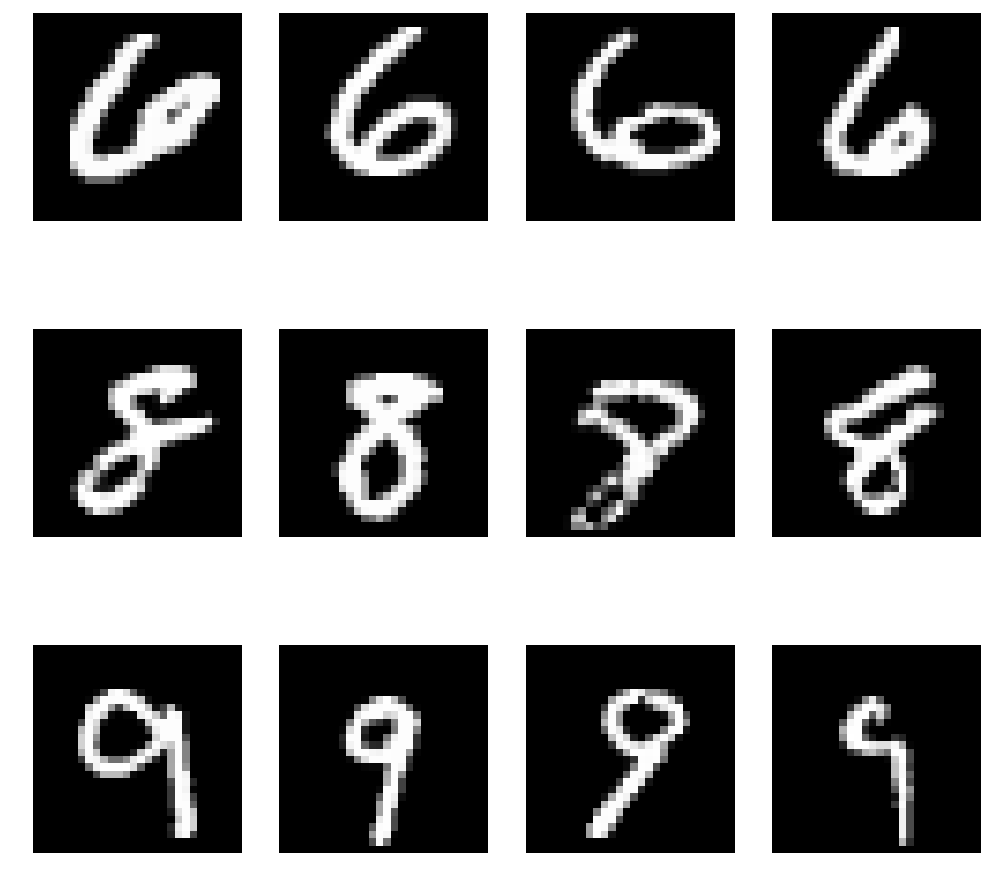

In [53]:
# generate a 3x4 grid of subplots
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(10,10))

# each row will be 6s, 8s, or 9s
i = 0
for ax in axs[0,:]:
    ax.imshow(pixel_mat(sixes_idx[i]), cmap=plt.cm.gray, origin='upper', interpolation='nearest')
    i += 1
    ax.axis('off')
i = 0
for ax in axs[1,:]:
    ax.imshow(pixel_mat(eights_idx[i]), cmap=plt.cm.gray, origin='upper', interpolation='nearest')
    i += 1
    ax.axis('off')
i = 0
for ax in axs[2,:]:
    ax.imshow(pixel_mat(nines_idx[i]), cmap=plt.cm.gray, origin='upper', interpolation='nearest')
    i += 1
    ax.axis('off')    
plt.tight_layout()   
plt.show()

Let's imagine looking at these images through a window of the pixels in the upper half of the image.

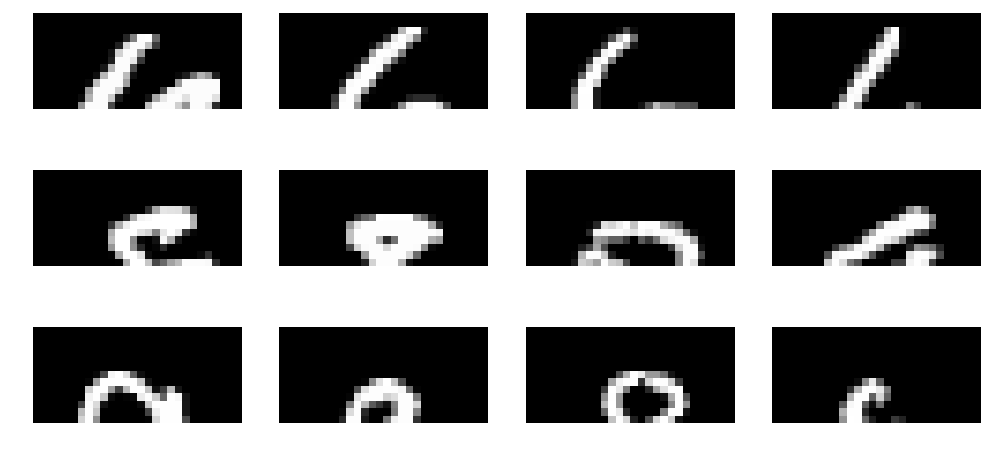

In [54]:
# recover the upper 14x28 block from the 28x28 matrix 
def upper_pixel_mat(row):
    # we're working with train_df so we want to drop the label column
    vec = train_df.drop('label', axis=1).iloc[row].values
    # numpy provides the reshape() function to reorganize arrays into specified shapes
    pixel_mat = vec.reshape(28,28)
    upper_pixel_mat = pixel_mat[0:13,:]
    return upper_pixel_mat


fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(10,5))

i = 0
for ax in axs[0,:]:
    ax.imshow(upper_pixel_mat(sixes_idx[i]), cmap=plt.cm.gray, origin='upper', interpolation='nearest')
    i += 1
    ax.axis('off')
i = 0
for ax in axs[1,:]:
    ax.imshow(upper_pixel_mat(eights_idx[i]), cmap=plt.cm.gray, origin='upper', interpolation='nearest')
    i += 1
    ax.axis('off')
i = 0
for ax in axs[2,:]:
    ax.imshow(upper_pixel_mat(nines_idx[i]), cmap=plt.cm.gray, origin='upper', interpolation='nearest')
    i += 1
    ax.axis('off')    
plt.tight_layout()   
plt.show()

Similarly look through a window in the lower half:

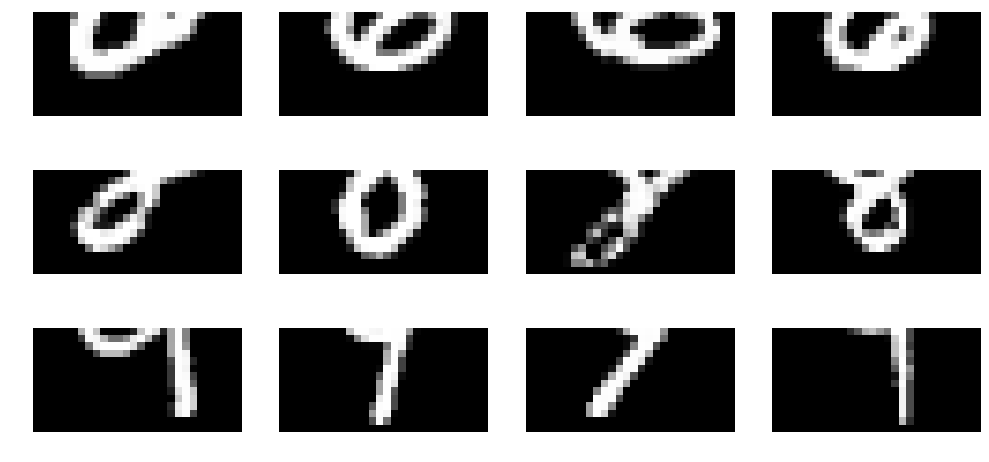

In [55]:
# recover the lower 14x28 block from the 28x28 matrix 
def lower_pixel_mat(row):
    # we're working with train_df so we want to drop the label column
    vec = train_df.drop('label', axis=1).iloc[row].values
    # numpy provides the reshape() function to reorganize arrays into specified shapes
    pixel_mat = vec.reshape(28,28)
    lower_pixel_mat = pixel_mat[14:28,:]
    return lower_pixel_mat


fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(10,5))

i = 0
for ax in axs[0,:]:
    ax.imshow(lower_pixel_mat(sixes_idx[i]), cmap=plt.cm.gray, origin='upper', interpolation='nearest')
    i += 1
    ax.axis('off')
i = 0
for ax in axs[1,:]:
    ax.imshow(lower_pixel_mat(eights_idx[i]), cmap=plt.cm.gray, origin='upper', interpolation='nearest')
    i += 1
    ax.axis('off')
i = 0
for ax in axs[2,:]:
    ax.imshow(lower_pixel_mat(nines_idx[i]), cmap=plt.cm.gray, origin='upper', interpolation='nearest')
    i += 1
    ax.axis('off')    
plt.tight_layout()   
plt.show()

We can imagine training an early layer of our network to recognize a closed loop, then a later layer could learn the table:

| loop in upper window | loop in lower window | digit     |
|----------------------|----------------------|-----------|
|         0            |         0            | not 6,8,9 |
|         1            |         0            |      9    |
|         0            |         1            |      6    |
|         1            |         1            |      8    |

A sketch of a convolutional layer being fed into a regular feedforward layer might look like:

![convolutional layer into feedforward layer](convolution1.png)

It is not to hard to guess that the convolutional network will have the hyperparameters:

1. The shape [width, height] of the window employed to sample groups of pixels.  The window is also referred to as the **filter**.

2. The number of pixels in each direction to move the window between samplings.  This is called the **stride**.

3. The number of features to compute per sampling.  This is referred to as the **depth**. If depth > 1, then the filter is actually a tensor of shape [width, height, depth].

Convolutional layers tend to learn geometric shapes.  In the case of the digits, depending on the filter size, these might look like the highlighted shapes:

![convolutional features](convfeat.png)

Because using the filter is equivalent to sharing weights,  the convolutional layer learns these features wherever they might be found in the image.  The **parameter sharing** introduces a degree of **translational invariance** to the learning algorithm.  Because of the stride, we also retain information in the computed features about where in a particular image a feature is found.   We learn a set of important features that might be present in many types of digits, then the appearance and location in a particular digit helps the network classify that digit.

### Pooling

We have seen that many of the handwritten digits do contain many features in common, but they tend to be slightly displaced from digit to digit. As an example, consider these 4s:

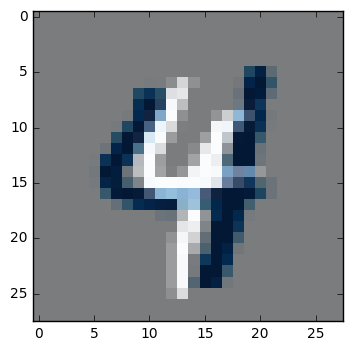

In [56]:
plt.figure(1)
plt.imshow(pixel_mat(33093), cmap=plt.cm.gray, origin='upper', interpolation='nearest')
plt.imshow(pixel_mat(9662)-1, cmap=plt.cm.Blues, origin='upper', interpolation='nearest', alpha=0.5)
   
plt.show()

In addition to convolution with a stride, another way of introducing more translational invariance to the model is to use **pooling**.  A pooling layer replaces the inputs of nearby points with an output corresponding to an aggregation of the nearby inputs.  In this notebook, we'll be using **max pooling**, which replaces the inputs with the maximum input found in a rectangular neighborhood.  A cartoon version might look like:

![2x2 max pooling](maxpool.png)

Pooling tends to make a model focus on the most prominent features, regardless of their precise location.

We have only briefly touched on the explanation and utility of convolution and pooling. The interested reader is encouraged to learn more details at, e.g., https://www.deeplearningbook.org


Let us use TensorFlow to put a network together that uses convolutional, pooling and conventional feedforward layers. This will be our first example of a **deep network**.

In [57]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

The network will have the same input and output layers as before.

In [58]:
n_feat = 784
x = tf.placeholder(tf.float32, shape=[None, n_feat])
n_class = 10
y_true = tf.placeholder(tf.int32, shape=[None, n_class])

Our first layer will be 2d convolutional from the TF op tf.nn.conv2d.  Instead of taking a normal design matrix, this op takes an input which is a tensor of shape [batch, in_height, in_width, in_channels], where: 

batch is the number of observations in the data. <BR>
(in_height, in_width) are the pixel dimensions of the input images.  In our case these are both = 28.  <BR>
in_channels is the number of color channels in the input.  Since our images are greyscale, this is just = 1. <BR>

Therefore, to apply the first convolutional layer, we need to reshape our input as follows:

In [59]:
x_image = tf.reshape(x, [-1,28,28,1])

The layer also applies a filter/kernel of shape [filter_height, filter_width, in_channels, out_channels], where:

(filter_height, filter_width) are the pixel dimensions of the window. <BR>
in_channels is again the # of color channels in the input.  <BR>
out_channels is the number of features for the layer to output. <BR>

The layer samples patches of the image to form: 

a tensor X of shape [batch, out_height, out_width, filter_height $*$ filter_width $*$ in_channels]. <BR> 
flattens the filter into a tensor W of shape [filter_height $*$ filter_width $*$ in_channels, output_channels].<BR> 
computes the matrix product  X.W, which is a tensor of shape [batch, out_height, out_width, output_channels].

We specify the filter by defining a weight tensor of the appropriate shape.  For a 5x5 window, the weights will have shape [5, 5, 1, n_features_out], where n_features_out is the number of features we want the CNN layer to compute. We will compute 16 features in this first layer, due to memory constraints. 

We also have to decide the stride for the layer,  which is the amount we shift the window between samplings. We specify the stride using a vector containing the information [batch, horizontal_stride, vertical_stride, in_channels]. Stride is constrained to sample one batch input and one input channel at a time, so the stride vector must be given in the form [1, horizontal_stride, vertical_stride, 1]. If we just shift the window by one pixel in either direction for samplings, the stride tensor should be [1, 1, 1, 1].

If we were to just sample 5x5  windows on a 28x28 pixel image, the output would be a 24x24 image. Further CNN and pooling layers would shrink this down even further to the point where we can't apply CNN anymore.  The solution to this is to pad the image with blank pixels in the output to, in our case, keep the output as a 28x28 image, no matter what other transformation we apply to it.  The layers take an argument to specify the type of padding, if any, that we want to apply.

Finally we apply the rectified linear unit as an activation function for this layer.

Putting all of this together, the layer we want is specified by:

In [60]:
n_convfeat1 = 16

W_conv1 = weight_variable([5, 5, 1, n_convfeat1])
b_conv1 = bias_variable([n_convfeat1])

CNN1 = tf.nn.conv2d(x_image, W_conv1, strides=[1, 1, 1, 1], padding='SAME')
h_conv1 = tf.nn.relu(tf.add(CNN1, b_conv1))

In [61]:
h_conv1

<tf.Tensor 'Relu:0' shape=(?, 28, 28, 16) dtype=float32>

As promised, the output of this layer is a 28x28 "image" with 8 features per pixel. 

The next layer will be a pooling layer.  We will follow the tutorial and use max pooling via the op tf.nn.max_pool. Max pooling reports the maximum output for a given feature in a specified area, which this op expects to be a rectangle.   More specifically, the input has shape
[batch, height, width, channels] and the window is also specified according to these dimensions. 

We want to max pool over 2x2 windows, so we must specify the shape list [1, 2, 2, 1].   This samples once per input image and feature, but performs max pooling over the 2x2 geometric window.   Furthermore, we don't want our windows to overlap (that would not introduce enough translational invariance), so to shift by 2 pixels we specify the stride [1, 2, 2, 1].

Padding with the pooling op works differently from padding with the CNN ops.  Here we add padding if BEFORE the pooling transformation if it is necessary to carry out the specified pooling operation.  For instance, if we wanted to do 2x2 pooling with a stride of 2 on a 3x3 image, we would need to pad the image to 4x4.  Our output would be 2x2.

We specify this pooling layer via:

In [62]:
h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [63]:
h_pool1

<tf.Tensor 'MaxPool:0' shape=(?, 14, 14, 16) dtype=float32>

This is a 14x14 image with the same 8 features outputted by the CNN.  

Again following the tutuorial, we wish to introduce additional CNN and pooling layers.  We will choose the CNN to be 5x5 with unit stride and compute 16 features (again due to memory constraints), while we'll apply another instance of 2x2 max pooling with stride 2.  The output will be a 7x7 image with 16 features.

In [64]:
n_convfeat2 = 16

W_conv2 = weight_variable([5, 5, n_convfeat1, n_convfeat2])
b_conv2 = bias_variable([n_convfeat2])

CNN2 = tf.nn.conv2d(h_pool1, W_conv2, strides=[1, 1, 1, 1], padding='SAME')
h_conv2 = tf.nn.relu(tf.add(CNN2, b_conv2))

h_pool2 = tf.nn.max_pool(h_conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
h_pool2

<tf.Tensor 'MaxPool_1:0' shape=(?, 7, 7, 16) dtype=float32>

Our fully connected single layer NN was working pretty well so we will include one as the next layer. We will choose a width of 512 to keep the total memory usage of the full network reasonalbe.  We will flatten the 7x7 image into a pixel vector to make the computations more convenient.

In [65]:
width1 = 512

W_1 = weight_variable([7 * 7 * n_convfeat2, width1])
b_1 = bias_variable([width1])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*n_convfeat2])

h_1 = tf.nn.relu(tf.add(tf.matmul(h_pool2_flat, W_1), b_1))

As before,  we'll introduce a dropout layer.

In [66]:
keep_prob = tf.placeholder(tf.float32)
h_1_drop = tf.nn.dropout(h_1, keep_prob)

And output layer.

In [67]:
W_out = weight_variable([width1, n_class])
b_out = bias_variable([n_class])

z_out = tf.add(tf.matmul(h_1_drop, W_out), b_out)

The rest of the choices will also be the same.

In [68]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=z_out))
corr = tf.equal(tf.argmax(z_out, 1), tf.argmax(y_true, 1))    
accr = tf.reduce_mean(tf.cast(corr, "float"))

learning_rate = 0.001
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [69]:
# Number of epochs to train over. Should be large enough for convergence.  If it is too large, at worst the model
# might overfit, at best we waste computing time.
n_epoch = 40

# In order to monitor training progress, as well as tune n_epoch, we will computing appropriate 
# metrics at checkpoints
display_step = 5

# initialize variables
sess.run(tf.global_variables_initializer())

start = time()
for epoch in range(n_epoch):
    # init average cost 
    avg_cost = 0.
    
    # enumerate(skfold.split(x,y)) returns a triple of the form (fold, train indices, test indices)
    # minibatch indices are the test indices, labeled batch_idx here.
    # the training indices are not used, we just assign them to dummy_idx
    # fold is the number of the fold in range(total_batch)
    # One loop over the folds is a single epoch.
    # Note also that we use the ordinal class labels in y_training because StratifiedKFold wouldn't work with the
    # one-hot encoding
    for fold, (dummy_idx, batch_idx) in enumerate(skfold.split(x_training_scaled, y_training)):
        # extract design matrix and response array for minibatch
        # here we can use the one-hot response array
        x_batch, y_batch = x_training_scaled[batch_idx], y_training_oh[batch_idx]
        # run backprop and feedforward
        # we assign the cost per example to c
        # Note the feed_dict contains the minibatch data
        _, c = sess.run([optimizer, cost], feed_dict={x: x_batch, y_true: y_batch, keep_prob: 0.5})
        # Compute average cost
        avg_cost += c / total_batch
        
    # Display logs per epoch step
    if epoch % display_step == 0:
        # return epoch and average cost
        print("Epoch: %04d" % epoch, "cost = %04f" % avg_cost)
        # compute accuracy on full training set
        train_acc = sess.run(accr, feed_dict={x: x_training_scaled, y_true: y_training_oh, keep_prob: 1.})
        print ("TRAIN ACCURACY: %.3f" % (train_acc))
        # compute accuracy on full validation set
        test_acc = sess.run(accr, feed_dict={x: x_validation_scaled, y_true: y_validation_oh, keep_prob: 1.})
        print ("VALIDATION ACCURACY: %.3f" % (test_acc))

# After the full training cycle, return more logs
train_acc = sess.run(accr, feed_dict={x: x_training_scaled, y_true: y_training_oh, keep_prob: 1.})      
test_acc = sess.run(accr, feed_dict={x: x_validation_scaled, y_true: y_validation_oh, keep_prob: 1.})
print("Optimization finished in %.2f seconds!" % (time() - start)) 
print("For n_convfeat1 = %d, n_convfeat2 = %d, width1 = %d, n_epoch = %d," \
      % (n_convfeat1, n_convfeat2, width1, n_epoch))
print ("TRAIN ACCURACY: %.3f" % (train_acc))
print ("VALIDATION ACCURACY: %.3f" % (test_acc))   


('Epoch: 0000', 'cost = 0.360355')
TRAIN ACCURACY: 0.974
VALIDATION ACCURACY: 0.970
('Epoch: 0005', 'cost = 0.040597')
TRAIN ACCURACY: 0.995
VALIDATION ACCURACY: 0.988
('Epoch: 0010', 'cost = 0.020372')
TRAIN ACCURACY: 0.998
VALIDATION ACCURACY: 0.988
('Epoch: 0015', 'cost = 0.012234')
TRAIN ACCURACY: 0.999
VALIDATION ACCURACY: 0.989
('Epoch: 0020', 'cost = 0.007932')
TRAIN ACCURACY: 0.999
VALIDATION ACCURACY: 0.988
('Epoch: 0025', 'cost = 0.008119')
TRAIN ACCURACY: 1.000
VALIDATION ACCURACY: 0.990
('Epoch: 0030', 'cost = 0.006266')
TRAIN ACCURACY: 0.999
VALIDATION ACCURACY: 0.989
('Epoch: 0035', 'cost = 0.005779')
TRAIN ACCURACY: 1.000
VALIDATION ACCURACY: 0.990
Optimization finished in 1244.82 seconds!
For n_convfeat1 = 16, n_convfeat2 = 16, width1 = 512, n_epoch = 40,
TRAIN ACCURACY: 1.000
VALIDATION ACCURACY: 0.991


At 99% accuracy, this is our best model so far.  Some incremental gains can be made by increasing the number of features computed in the CNN layers and the fully connected layer.  The particular values here were conservatively chosen so that this notebook could be run comfortably with 8 GB of RAM.  

### Analysis of Errors

It might be useful to take a closer look at the examples in the validation set where our CNN got the wrong answer.  To obtain the output class probabilities for the validation set, we can run: 

In [70]:
y_pred_prob = sess.run(tf.nn.softmax(z_out), feed_dict={x: x_validation_scaled, y_true: y_validation_oh, keep_prob: 1.})

We can can check a random sample:

In [71]:
idxs = np.random.randint(0, len(y_pred_prob), 5)
y_pred_prob[idxs]

array([[  7.87773855e-23,   1.00000000e+00,   4.69222484e-21,
          3.04359115e-28,   6.00163148e-13,   1.04500818e-24,
          9.54637008e-22,   6.19501412e-13,   3.32869313e-22,
          6.52604992e-21],
       [  7.98164144e-31,   5.27375906e-21,   1.13850733e-24,
          3.67220467e-16,   1.80469534e-25,   1.00000000e+00,
          5.81068634e-19,   6.58538686e-23,   1.02938992e-20,
          8.14921630e-18],
       [  4.40622135e-14,   1.76250182e-15,   1.76425172e-14,
          4.94775619e-15,   5.30898632e-08,   9.14503039e-16,
          1.20785162e-14,   6.27664413e-12,   1.61770528e-11,
          1.00000000e+00],
       [  1.38174535e-18,   5.09927604e-12,   1.00000000e+00,
          5.54902368e-17,   1.77503614e-25,   3.30029278e-31,
          1.05908742e-22,   1.59847179e-14,   1.32088270e-17,
          1.11353132e-30],
       [  3.10690266e-20,   3.58529717e-09,   9.81141472e-15,
          1.40916235e-21,   1.00000000e+00,   1.46991158e-19,
          4.19736484e-13

We can use argmax to compute the most probable prediction for each example:

In [72]:
y_pred = np.argmax(y_pred_prob, 1)
y_pred

array([7, 9, 1, ..., 3, 9, 1])

These are to be compared with the list of true labels from y_validation, which we can reobtain by also applying argmax:

In [73]:
y_act = np.argmax(y_validation_oh, 1)
y_act

array([7, 9, 1, ..., 3, 9, 1])

Another useful numpy function is argsort, which returns the indices that would sort an array, from smallest element to largest. In our case, it is more convenient to sort from largest to smallest, in which case we can specify np.argsort(-vec). In the case of our class probability vectors, the first entry in argsort(-vec) will be the argmax, while the next will be the 2nd most probable class, then the 3rd and so on.  It can be useful to know if the true label was given a relatively high probability if the most probable model class was incorrect. For example, we can consider

In [74]:
print(y_pred_prob[idxs])
print(np.argsort(-y_pred_prob[idxs]))
print(np.argmax(y_pred_prob[idxs], 1))

[[  7.87773855e-23   1.00000000e+00   4.69222484e-21   3.04359115e-28
    6.00163148e-13   1.04500818e-24   9.54637008e-22   6.19501412e-13
    3.32869313e-22   6.52604992e-21]
 [  7.98164144e-31   5.27375906e-21   1.13850733e-24   3.67220467e-16
    1.80469534e-25   1.00000000e+00   5.81068634e-19   6.58538686e-23
    1.02938992e-20   8.14921630e-18]
 [  4.40622135e-14   1.76250182e-15   1.76425172e-14   4.94775619e-15
    5.30898632e-08   9.14503039e-16   1.20785162e-14   6.27664413e-12
    1.61770528e-11   1.00000000e+00]
 [  1.38174535e-18   5.09927604e-12   1.00000000e+00   5.54902368e-17
    1.77503614e-25   3.30029278e-31   1.05908742e-22   1.59847179e-14
    1.32088270e-17   1.11353132e-30]
 [  3.10690266e-20   3.58529717e-09   9.81141472e-15   1.40916235e-21
    1.00000000e+00   1.46991158e-19   4.19736484e-13   1.90725370e-11
    2.48729849e-16   7.22438239e-17]]
[[1 7 4 9 2 6 8 0 5 3]
 [5 3 9 6 8 1 7 2 4 0]
 [9 4 8 7 0 2 6 3 1 5]
 [2 1 7 3 8 0 6 4 9 5]
 [4 1 7 6 2 8 9 5 0 3]

It is also interesting to look at the confusion matrix:

In [75]:
from sklearn.metrics import confusion_matrix

import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

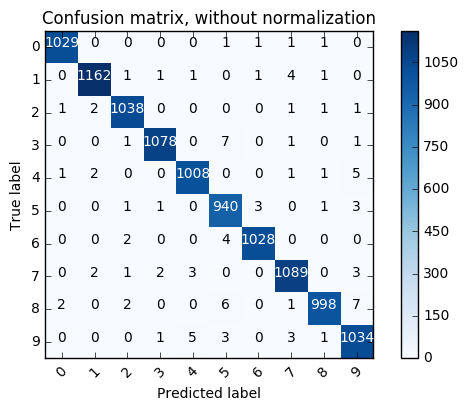

In [76]:
conf_mat = confusion_matrix(y_act, y_pred)

plt.figure()
plot_confusion_matrix(conf_mat, classes=range(10), title='Confusion matrix, without normalization')
plt.show()

The model does well, as expected from the accuracy score.  Some observations, though the statistics of errors is based on small samples:

* 1s are interpreted as 7s, as we might have expected.
* 3s are confused with 5s, but not vice-versa.
* 4s tend to get confused with 9s.
* 6s get confused with 5s, which is a bit expected.
* 7s get confused a bit with 1s, 4s, and 9s.
* 8s are confused with 5s and 9s, but not vice-versa.
* 9s are confused with 4s, 5s and 7s.  This is somewhat understandable.

We will examine a couple examples where the model was confused between 4s and 9s a bit later.

In order to compare with the features in the corresponding design matrix, x_validation, we can use the numpy where function to obtain the indices for the events where the prediction was different from the true value:

In [77]:
error_idx = np.where(y_pred != y_act)[0]

In [78]:
error_idx

array([   29,   342,   479,   833,   835,  1151,  1220,  1313,  1395,
        1651,  1748,  1884,  1989,  2015,  2049,  2229,  2314,  2343,
        2403,  2465,  2826,  2862,  2996,  3034,  3069,  3081,  3248,
        3256,  3273,  3341,  3453,  3469,  3478,  3615,  3843,  3909,
        4139,  4193,  4201,  4296,  4503,  4574,  4787,  4829,  4849,
        4870,  4907,  4920,  5099,  5153,  5165,  5179,  5332,  5390,
        5458,  5509,  5609,  6148,  6184,  6248,  6276,  6319,  6391,
        6418,  6577,  6728,  6762,  6872,  7287,  7342,  7789,  7992,
        8040,  8201,  8235,  8576,  8601,  8612,  8639,  9029,  9076,
        9202,  9381,  9588,  9710,  9718,  9864,  9925, 10238, 10290,
       10326, 10390, 10413, 10438, 10441, 10484])

We can then adapt the code from the overview notebook and display a random set of digit images from the error set:

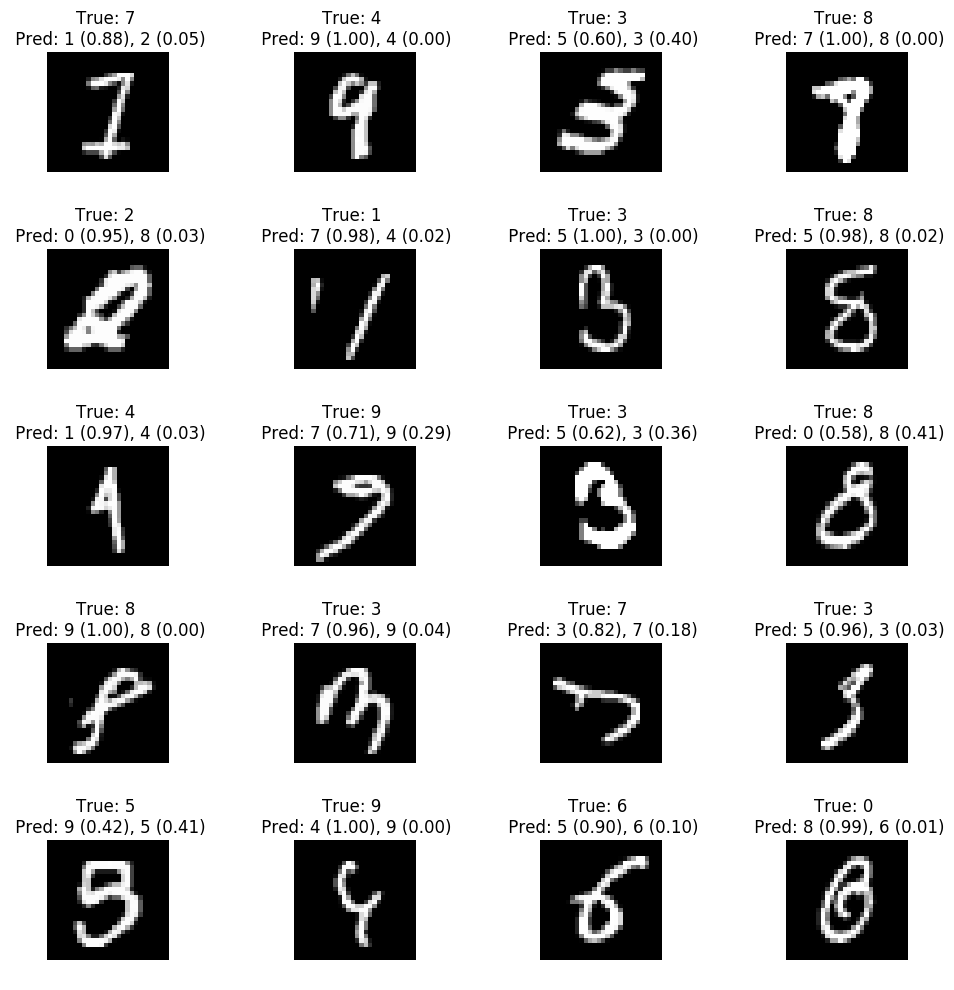

In [79]:
rand_idx = np.random.choice(error_idx, size=20, replace=False)
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(10,10))

i = 0
for ax in axs.reshape(-1):
    # cycle through the elements of rand_idx
    idx = rand_idx[i]
# this is the true class label
    true_y = y_act[idx]
    # this is the vector of model class probabilities
    prob_y = y_pred_prob[idx]
    # this is the most probable class
    top_pred = np.argmax(prob_y)
    # this is probability of the top class
    prob_top = prob_y[top_pred]
    # argsort the prob. vector
    arg_sort = np.argsort(-prob_y)
    # this is the 2nd choice class 
    sec_choice = arg_sort[1]
    # this is the probability of the 2nd choice class
    prob_sec = prob_y[sec_choice]
    
    
    ax.set_title("True: %d \n Pred: %d (%.2f), %d (%.2f)" % 
                 (true_y, top_pred, prob_top, sec_choice, prob_sec))
    ax.imshow(x_validation[idx].reshape(28,28), cmap=plt.cm.gray, origin='upper', interpolation='nearest')
    ax.axis('off')
    i += 1
plt.tight_layout()    
plt.show()

It is likely that several of these would be challenging for a human to identify with 100% accuracy, while others are quite obvious.   In some cases, it is easy to see what features that the neural network probably used to decide that the image more closely resembled a different digit than the true one.

For instance, for the following digit image, the CNN predicted "9" vs the true value of 4.

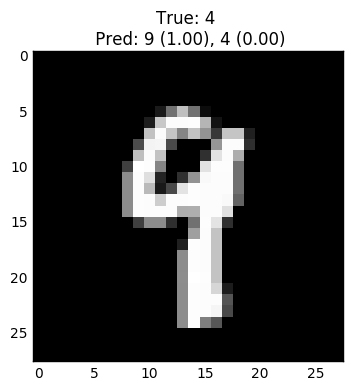

In [80]:
idx = 3453
# this is the true class label
true_y = y_act[idx]
# this is the vector of model class probabilities
prob_y = y_pred_prob[idx]
# this is the most probable class
top_pred = np.argmax(prob_y)
# this is probability of the top class
prob_top = prob_y[top_pred]
# argsort the prob. vector
arg_sort = np.argsort(-prob_y)
# this is the 2nd choice class 
sec_choice = arg_sort[1]
# this is the probability of the 2nd choice class
prob_sec = prob_y[sec_choice]
    
plt.imshow(x_validation[idx].reshape(28,28), cmap=plt.cm.gray, origin='upper', interpolation='nearest') 
plt.title("True: %d \n Pred: %d (%.2f), %d (%.2f)" % 
                 (true_y, top_pred, prob_top, sec_choice, prob_sec))
plt.show()

In this case, a human might not decide that this is a 4, at least not with total confidence. The vertical stem on the right of the digit rises to a height slightly less than the loopy hook on the left. The left hook is also pronouncedly curved, very nearly meeting the right stem. Finally the lower part of the loop meets the stem at an acute angle, rather than a perpendicular.  These features are more closely associated with a 9 than a 4. In fact, the model's 2nd choice is an 4, with around a 1 in 10^4 probability assigned.

In [81]:
y_pred_prob[3453]

array([  7.00451580e-17,   5.34233878e-14,   2.19945996e-15,
         3.45569670e-16,   4.43625314e-09,   6.15691838e-17,
         4.36081089e-19,   1.05184752e-12,   4.29371372e-10,
         1.00000000e+00], dtype=float32)

For the converse identification problem, we can look at the following example:

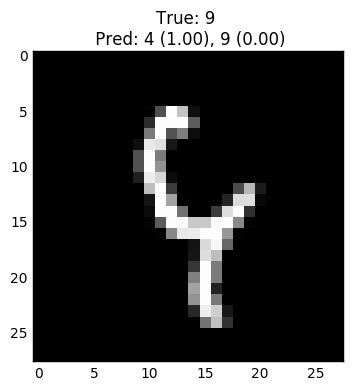

In [86]:
idx = 2403
# this is the true class label
true_y = y_act[idx]
# this is the vector of model class probabilities
prob_y = y_pred_prob[idx]
# this is the most probable class
top_pred = np.argmax(prob_y)
# this is probability of the top class
prob_top = prob_y[top_pred]
# argsort the prob. vector
arg_sort = np.argsort(-prob_y)
# this is the 2nd choice class 
sec_choice = arg_sort[1]
# this is the probability of the 2nd choice class
prob_sec = prob_y[sec_choice]
    
plt.imshow(x_validation[idx].reshape(28,28), cmap=plt.cm.gray, origin='upper', interpolation='nearest') 
plt.title("True: %d \n Pred: %d (%.2f), %d (%.2f)" % 
                 (true_y, top_pred, prob_top, sec_choice, prob_sec))
plt.show()

In this case, we have a  stubby, bent stem on the right that doesn't rise to the height of the left part of the digit.  The bottom of the loop meets the stem at almost 90 degrees, instead of the acute angle typically associated with a 9. The upper part of the loop also misses the top of the stem by a large margin.  These features probably explain why the CNN thought this was a 4.  In fact 9 was the 2nd choice, though with a < 1% probability.

As an exercise, you should see if you can find similar features in other misclassified examples that could help explain why the model failed.

## Conclusions

In this notebook, we learned how to use TensorFlow to construct machine learning models using very low-level tools.  TF allows us to define models in much more detail than scikit-learn, but at the cost of requiring quite a bit of expertise about how those models work in theory and are constructed in practice.

We also learned how to apply neural networks, including the multilevel perceptron and the convolutional neural networks to the MNIST digit problem.  We saw that they lead to improvements of almost 1% in validation accuracy vs our best Random Forest result.